# Facies classification from well logs with Convolutional Neural Networks (CNN)

## Shiang Yong Looi

Using Keras running on top for Tensorflow, we build two CNNs : first to impute PE on two wells with missing data and then for the main task of classifying facies. 

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, normalization, Convolution1D
from keras.callbacks import History
from keras.utils import np_utils
from keras.callbacks import History
from sklearn import metrics
from classification_utilities import display_cm

Using TensorFlow backend.


In [2]:
# Read in data
data = pandas.read_csv('./facies_vectors.csv')
Y_train = data[data['PE'].notnull()]['PE'].values

In [2]:
def prepare_feature_vectors(data, features, window_width):

    raw_feature_vectors = data[features]
    well_labels = data['Well Name']
    num_features = np.shape(raw_feature_vectors)[1]

    output = np.zeros((1, window_width, num_features))
    for x in well_labels.unique():
        well = raw_feature_vectors[well_labels == x].values
        well = np.concatenate((np.repeat(well[0:1], np.floor((window_width-1)/2.0), axis=0), well,
                              np.repeat(well[-1:None], np.floor(window_width/2.0), axis=0)), axis=0)

        tmp = np.zeros((np.size(well, axis=0) - window_width + 1, window_width, num_features))
        for i in np.arange(np.size(well, axis=0) - window_width + 1):
            tmp[i] = np.reshape(well[i: i + window_width], (window_width, num_features))

        output = np.append(output, tmp, axis=0)

    return output[1:]

In [ ]:
# Window around central value and list the six features we are using
window_width = 15
feature_list = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']
X_train = prepare_feature_vectors(data[data['PE'].notnull()], feature_list, window_width)
num_train_samples = np.asarray(np.shape(X_train))[0]

X_test = prepare_feature_vectors(data[data['PE'].isnull()], feature_list, window_width)
num_test_samples = np.asarray(np.shape(X_test))[0]

print('Training Samples=', num_train_samples, '   Test Samples=', num_test_samples)

In [4]:
# define neural network to perform regression on PE
num_filters = 12
dropout_prob = 0.6666

cnn = Sequential()
cnn.add(Convolution1D(num_filters, 1, border_mode='valid', input_shape=(window_width, len(feature_list))))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Convolution1D(num_filters, 3, border_mode='valid'))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Dropout(dropout_prob / 2))

cnn.add(Flatten())
cnn.add(Dense(4*num_filters))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Dropout(dropout_prob))

cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
cnn.summary()

# save initial weights, which are random
initial_weights = cnn.get_weights()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 15, 12)        84          convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 15, 12)        48          convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 15, 12)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 13, 12)        444         activation_1[0][0]               
___________________________________________________________________________________________

In [5]:
# define training parameters and prepare arrays to store training metrics
epochs_per_fold = 1000
num_fold = 5
roll_stride = np.ceil(num_train_samples/num_fold).astype(int)

cnn_hist = History()
hist = np.zeros((4, num_fold, epochs_per_fold))
f1scores = np.zeros(num_fold)
Y_test = np.zeros((num_test_samples, num_fold))


# shuffle input data
rand_perm = np.random.permutation(num_train_samples)
X_train = X_train[rand_perm]
Y_train = Y_train[rand_perm]

In [6]:
# use 5-fold cross validation and train 5 neural networks, ending up with 5 sets of predictions
for i in np.arange(num_fold):
    cnn.set_weights(initial_weights)
    X_train = np.roll(X_train, i*roll_stride, axis=0)
    Y_train = np.roll(Y_train, i*roll_stride, axis=0)

    cnn.fit(X_train, Y_train, batch_size=150, nb_epoch=epochs_per_fold, verbose=0,
                validation_split=1.0/num_fold, callbacks=[cnn_hist])

    # make predictions, i.e. impute PE
    Y_test[:, i] = cnn.predict(X_test)[:, 0]

    hist[:, i, :] = [cnn_hist.history['acc'], cnn_hist.history['val_acc'],
                     cnn_hist.history['loss'], cnn_hist.history['val_loss']]
    print("Accuracy  =", np.mean(hist[1, i, -100:]))

Accuracy  = 0.0407882538672


Accuracy  = 0.0382225654776


Accuracy  = 0.0284853169762


Accuracy  = 0.0382534782316


Accuracy  = 0.0403400312149


Mean Validation Accuracy  = 0.0372179291535


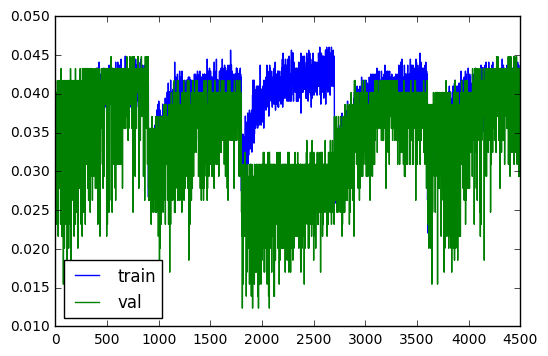

In [7]:
# plot callbacks to evaluate quality of training
drop_values = 100
drop_hist = np.reshape(hist[:, :, drop_values:], (4, num_fold * (epochs_per_fold - drop_values)))
print("Mean Validation Accuracy  =", np.mean(hist[1, :, -drop_values:]))

plt.plot(drop_hist[0]); plt.plot(drop_hist[1])
plt.legend(['train', 'val'], loc='lower left')

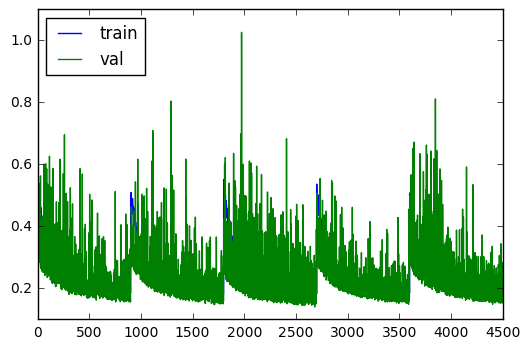

In [8]:
plt.plot(drop_hist[2]); plt.plot(drop_hist[3])
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# Update dataframe with imputed values by averaging results of 5 neural networks 
data['PE'][np.array(data['PE'].isnull())] = np.mean(Y_test, axis=1)

# Write intermediate data to file
data.to_csv('./ShiangYong/facies_vectors_imputedPE.csv', index=False)

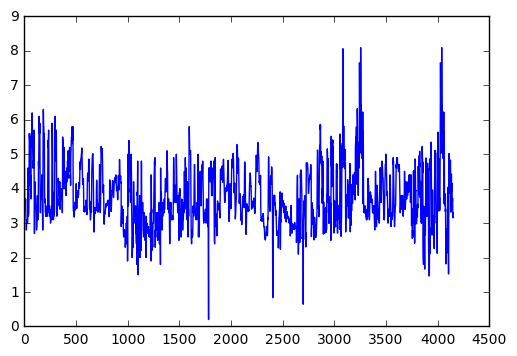

In [10]:
# Plot PE of all wells (original plus imputed) 
plt.plot(data['PE'])

At this point, we have a training dataset with imputed PE so we can proceed with the facies classification.

In [3]:
# Read in data with imputed PE, also read in two test wells
# data = pandas.read_csv('facies_vectors.csv')
data = pandas.read_csv('./ShiangYong/facies_vectors_imputedPE.csv')
blind_wells = pandas.read_csv('./nofacies_data.csv')

# Impute missing values with average if there are NaNs in PE
if data['PE'].isnull().any():
    data['PE'] = data['PE'].fillna(value=data['PE'].mean())

In [4]:
# Convert facies class to one-hot-vector representation
num_classes = data['Facies'].unique().size
Y_train = np_utils.to_categorical(data['Facies'].values-1, num_classes)

# Window around central value and define the seven features we are using
window_width = 15
feature_list = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
X_train = prepare_feature_vectors(data, feature_list, window_width)
X_test = prepare_feature_vectors(blind_wells, feature_list, window_width)

num_train_samples = np.asarray(np.shape(X_train))[0]
num_test_samples = np.asarray(np.shape(X_test))[0]

print('Training Samples=', num_train_samples, '   Test Samples=', num_test_samples)

Training Samples= 4149    Test Samples= 830


In [5]:
# define neural network to classify facies
num_filters = 12
dropout_prob = 0.6

convnet = Sequential()
convnet.add(Convolution1D(num_filters, 1, border_mode='valid',
                          input_shape=(window_width, len(feature_list))))
convnet.add(Activation('relu'))
convnet.add(Convolution1D(7, 1, border_mode='valid'))
convnet.add(Activation('relu'))
convnet.add(Convolution1D(num_filters, 3, border_mode='valid'))
convnet.add(Activation('relu'))
convnet.add(Dropout(dropout_prob / 2))

convnet.add(Flatten())
convnet.add(Dense(4 * num_filters))
convnet.add(normalization.BatchNormalization())
convnet.add(Activation('sigmoid'))
convnet.add(Dropout(dropout_prob))

convnet.add(Dense(num_classes, activation='softmax'))
convnet.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
convnet.summary()

# save initial weights
initial_weights = convnet.get_weights()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 15, 12)        96          convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 15, 12)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 15, 7)         91          activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 15, 7)         0           convolution1d_2[0][0]            
___________________________________________________________________________________________

In [7]:
# define training parameters and prepare arrays to store training metrics
epochs_per_fold = 1500
num_fold = 6
roll_stride = np.ceil(num_train_samples/num_fold).astype(int)

convnet_hist = History()
hist = np.zeros((4, num_fold, epochs_per_fold))
f1scores = np.zeros(num_fold)
Y_test_ohv = np.zeros((num_test_samples, num_fold, num_classes))


# shuffle input data
rand_perm = np.random.permutation(num_train_samples)
X_train = X_train[rand_perm]
Y_train = Y_train[rand_perm]

In [8]:
# use 6-fold cross validation and train 6 neural networks, ending up with 6 sets of predictions
for i in np.arange(num_fold):
    convnet.set_weights(initial_weights)
    X_train = np.roll(X_train, i*roll_stride, axis=0)
    Y_train = np.roll(Y_train, i*roll_stride, axis=0)

    convnet.fit(X_train, Y_train, batch_size=200, nb_epoch=epochs_per_fold, verbose=0,
                validation_split=1.0/num_fold, callbacks=[convnet_hist])

    hist[:, i, :] = [convnet_hist.history['acc'], convnet_hist.history['val_acc'],
                     convnet_hist.history['loss'], convnet_hist.history['val_loss']]

    Y_predict = 1 + np.argmax(convnet.predict(X_train), axis=1)
    f1scores[i] = metrics.f1_score(1 + np.argmax(Y_train, axis=1), Y_predict, average='micro')
    print('F1 Score =', f1scores[i])

    Y_test_ohv[:, i, :] = convnet.predict(X_test)
    
print('Average F1 Score =', np.mean(f1scores))

F1 Score = 0.664015425404


F1 Score = 0.662328271873


F1 Score = 0.671487105327


F1 Score = 0.700168715353


F1 Score = 0.698240539889


F1 Score = 0.660400096409
Average F1 Score = 0.676106692376


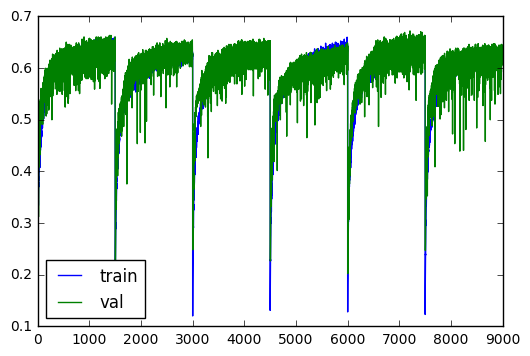

In [9]:
# Plot callbacks
hist = np.reshape(hist, (4, num_fold * epochs_per_fold))
plt.plot(hist[0]); plt.plot(hist[1])
plt.legend(['train', 'val'], loc='lower left')

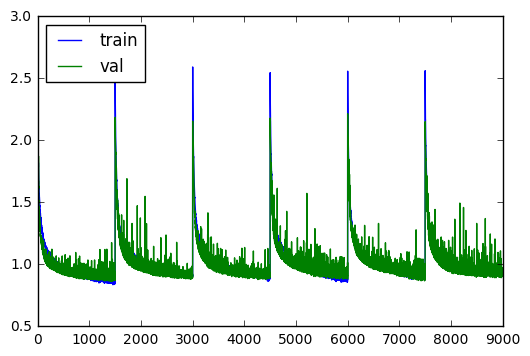

In [10]:
plt.plot(hist[2]); plt.plot(hist[3])
plt.legend(['train', 'val'], loc='upper left')

In [11]:
# Soft majority voting on 6 predictions to produce final prediction 
Y_test = 1 + np.argmax(np.sum(Y_test_ohv, axis=1), axis=1)

# Append predictions to dataframe and write to file
blind_wells['Facies'] = Y_test
blind_wells.to_csv('./ShiangYong/predicted_facies_ver04.csv', index=False)